In [1]:
!pip install tensorflow-decision-forests tensorflowjs keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
import os
import sys
import math
import time
import cv2
import datetime
import zoneinfo
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import keras
import pathlib
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Flatten, Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import keras_tuner as kt
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from PIL import Image
import io
from tqdm import tqdm
import glob
from google.colab import drive

In [3]:
# Configuraciones para la Busqueda de Hiperparametros
TUNING_MAX_EPOCHS = 10
OBJECTIVE = "val_accuracy"
FACTOR = 3
EPT = 1
N_EPOCHS = 25
BATCH_SIZE = 256

# Configuraciones para el Procesamiento de Imagenes
IMG_RESIZE_W_H = 224
TFREC_ROOT = "/content"
OUTPUT_ROOT = "/content/flowers_by_name"

# Listado de Clases (Fuente: Kaggle)
CLASSES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "wild geranium",
           "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle",
           "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris",
           "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily",
           "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth",
           "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william",
           "carnation", "garden phlox", "love in the mist", "cosmos", "alpine sea holly",
           "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose",
           "barberton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue",
           "wallflower", "marigold", "buttercup", "daisy", "common dandelion",
           "petunia", "wild pansy", "primula", "sunflower", "lilac hibiscus",
           "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia",
           "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy",
           "osteospermum", "spring crocus", "iris", "windflower", "tree poppy",
           "gazania", "azalea", "water lily", "rose", "thorn apple",
           "morning glory", "passion flower", "lotus", "toad lily", "anthurium",
           "frangipani", "clematis", "hibiscus", "columbine", "desert-rose",
           "tree mallow", "magnolia", "cyclamen ", "watercress", "canna lily",
           "hippeastrum ", "bee balm", "pink quill", "foxglove", "bougainvillea",
           "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower",
           "trumpet creeper", "blackberry lily", "common tulip", "wild rose"]

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
!unzip -q "/content/drive/My Drive/Colab Notebooks/flowers_100plus_224_224/tfrecords-jpeg-224x224.zip" -d "/content"

In [6]:
feature_description_with_class = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "class": tf.io.FixedLenFeature([], tf.int64),
    "id": tf.io.FixedLenFeature([], tf.string),
}

feature_description_without_class = {
    "image": tf.io.FixedLenFeature([], tf.string),
    "id": tf.io.FixedLenFeature([], tf.string),
}

def _parse_function(example_proto, has_class=True):
    feature_description = feature_description_with_class if has_class else feature_description_without_class
    return tf.io.parse_single_example(example_proto, feature_description)

def convert_split(split):
    tfrecord_files = glob.glob(os.path.join(TFREC_ROOT, split, "*.tfrec"))
    split_output_dir = os.path.join(OUTPUT_ROOT, split)
    os.makedirs(split_output_dir, exist_ok=True)

    has_class = split in ["train", "val"]

    for tfrec_file in tfrecord_files:
        raw_dataset = tf.data.TFRecordDataset(tfrec_file)
        parsed_dataset = raw_dataset.map(lambda x: _parse_function(x, has_class))

        for example in tqdm(parsed_dataset, desc=f"[{split}] {os.path.basename(tfrec_file)}"):
            image_bytes = example["image"].numpy()
            image_id = example["id"].numpy().decode()

            if has_class:
                class_id = example["class"].numpy()
                class_name = CLASSES[class_id].strip().replace(" ", "_").replace("/", "_")
            else:
                class_name = "unknown"

            class_dir = os.path.join(split_output_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            image = tf.image.decode_jpeg(image_bytes, channels=3)
            image = tf.image.resize(image, (IMG_RESIZE_W_H, IMG_RESIZE_W_H))
            image = tf.cast(image, tf.uint8).numpy()

            img = Image.fromarray(image)
            img.save(os.path.join(class_dir, f"{image_id}.jpg"))

for split in ["train", "val", "test"]:
    convert_split(split)

[train] 13-224x224-798.tfrec: 798it [00:02, 300.62it/s]
[train] 07-224x224-798.tfrec: 798it [00:02, 310.67it/s]
[train] 14-224x224-798.tfrec: 798it [00:02, 306.58it/s]
[train] 04-224x224-798.tfrec: 798it [00:02, 310.49it/s]
[train] 08-224x224-798.tfrec: 798it [00:02, 314.46it/s]
[train] 06-224x224-798.tfrec: 798it [00:02, 313.64it/s]
[train] 02-224x224-798.tfrec: 798it [00:02, 316.21it/s]
[train] 15-224x224-783.tfrec: 783it [00:02, 311.00it/s]
[train] 01-224x224-798.tfrec: 798it [00:02, 295.58it/s]
[train] 03-224x224-798.tfrec: 798it [00:02, 314.08it/s]
[train] 10-224x224-798.tfrec: 798it [00:02, 316.64it/s]
[train] 00-224x224-798.tfrec: 798it [00:02, 297.13it/s]
[train] 09-224x224-798.tfrec: 798it [00:02, 294.73it/s]
[train] 05-224x224-798.tfrec: 798it [00:02, 305.10it/s]
[train] 11-224x224-798.tfrec: 798it [00:02, 302.35it/s]
[train] 12-224x224-798.tfrec: 798it [00:02, 307.55it/s]
[val] 03-224x224-232.tfrec: 232it [00:00, 277.00it/s]
[val] 09-224x224-232.tfrec: 232it [00:00, 273.73it

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset_dir = pathlib.Path(OUTPUT_ROOT + "/train")
val_dataset_dir = pathlib.Path(OUTPUT_ROOT + "/val")
test_dataset_dir = pathlib.Path(OUTPUT_ROOT + "/test")

train_dataset = keras.utils.image_dataset_from_directory(
    train_dataset_dir,
    image_size=(IMG_RESIZE_W_H, IMG_RESIZE_W_H),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_dataset = keras.utils.image_dataset_from_directory(
    val_dataset_dir,
    validation_split=0.5,
    subset="training",
    seed=42,
    image_size=(IMG_RESIZE_W_H, IMG_RESIZE_W_H),
    batch_size=BATCH_SIZE
)

test_dataset = keras.utils.image_dataset_from_directory(
    val_dataset_dir,
    validation_split=0.5,
    subset="validation",
    seed=42,
    image_size=(IMG_RESIZE_W_H, IMG_RESIZE_W_H),
    batch_size=BATCH_SIZE
)

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.2)
])

def preprocess_train(image, label):
    image = data_augmentation(image)
    image = preprocess_input(image)
    return image, label

def preprocess_eval(image, label):
    image = preprocess_input(image)
    return image, label

train_ds = train_dataset.map(preprocess_train, num_parallel_calls=AUTOTUNE)
val_ds = val_dataset.map(preprocess_eval, num_parallel_calls=AUTOTUNE)
test_ds = test_dataset.map(preprocess_eval, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

print(f"Lotes del Conjunto de Entrenamiento: {tf.data.experimental.cardinality(train_ds).numpy()}")
print(f"Lotes del Conjunto de Validacion: {tf.data.experimental.cardinality(val_ds).numpy()}")
print(f"Lotes del Conjunto de Prueba: {tf.data.experimental.cardinality(test_ds).numpy()}")

Found 12753 files belonging to 104 classes.
Found 3712 files belonging to 104 classes.
Using 1856 files for training.
Found 3712 files belonging to 104 classes.
Using 1856 files for validation.
Lotes del Conjunto de Entrenamiento: 50
Lotes del Conjunto de Validacion: 8
Lotes del Conjunto de Prueba: 8


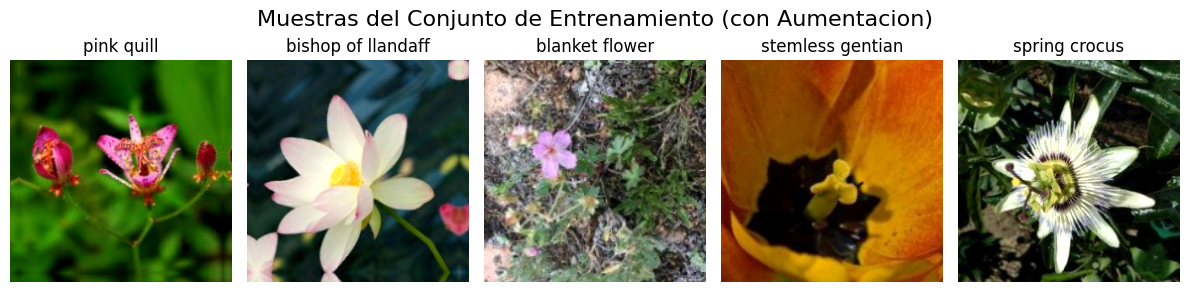

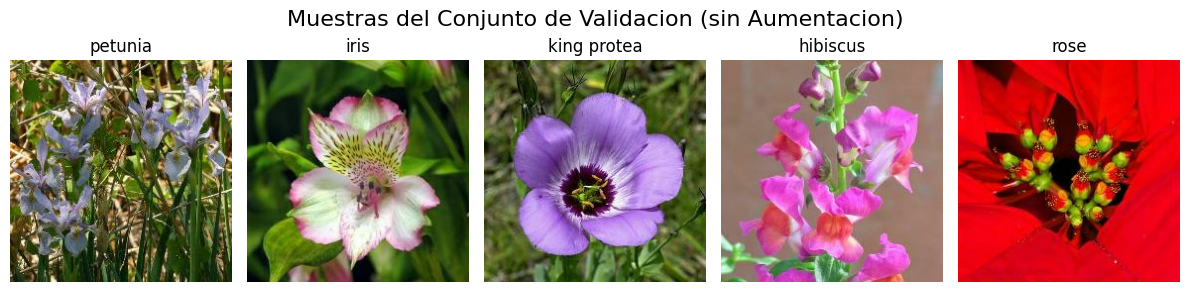

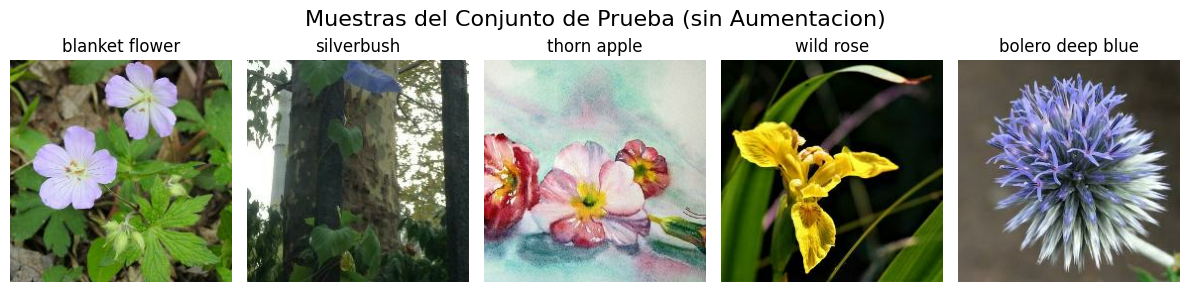

In [13]:
def show_sample_images(dataset, title, n=5):
    plt.figure(figsize=(12, 3))
    for images, labels in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(CLASSES[labels[i]])
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

show_sample_images(train_ds, "Muestras del Conjunto de Entrenamiento (con Aumentacion)")
show_sample_images(val_ds, "Muestras del Conjunto de Validacion (sin Aumentacion)")
show_sample_images(test_ds, "Muestras del Conjunto de Prueba (sin Aumentacion)")

<ipython-input-14-45e3b561b8e5>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=counts, ax=ax1, palette="rocket")


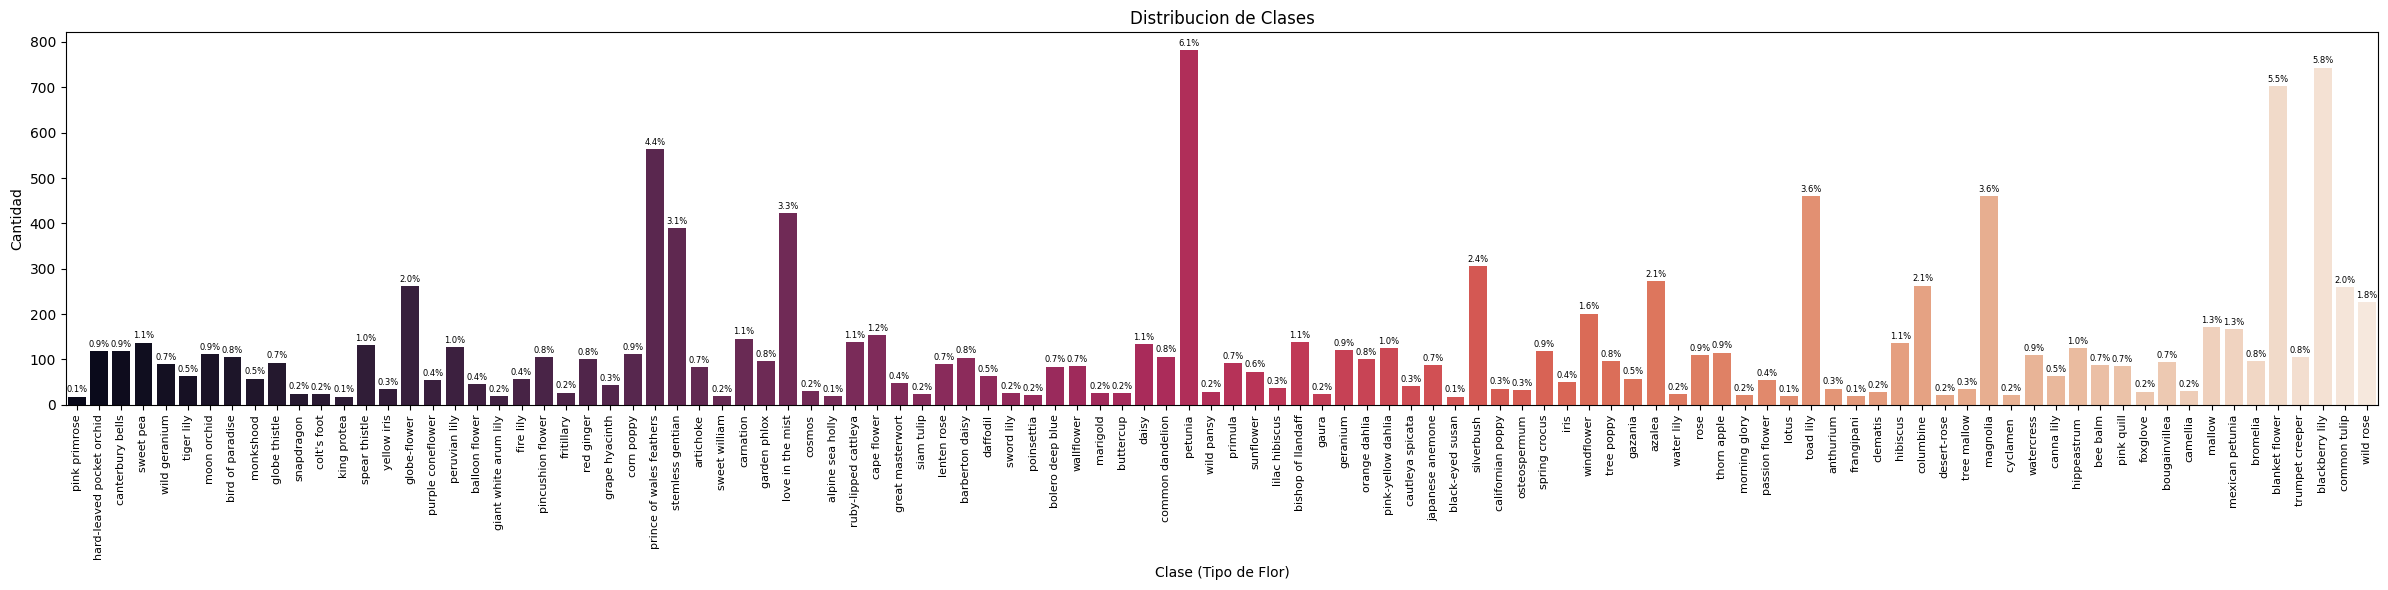

In [14]:
class_counts = Counter(np.concatenate([y.numpy() for _, y in train_ds], axis=0))
total_count = sum(class_counts.values())

labels = sorted(class_counts.keys())
counts = [class_counts[label] for label in labels]
class_labels = [CLASSES[label] for label in labels]

fig1, ax1 = plt.subplots(figsize=(24, 6))
sns.barplot(x=class_labels, y=counts, ax=ax1, palette="rocket")

ax1.set_title("Distribucion de Clases")
ax1.set_xlabel("Clase (Tipo de Flor)")
ax1.set_ylabel("Cantidad")

plt.xticks(rotation=90, fontsize=8)

for i, count in enumerate(counts):
    percentage = (count / total_count) * 100
    ax1.text(i, count + 5, f"{percentage:.1f}%", ha="center", va="bottom", fontsize=6)

plt.tight_layout()
plt.show()

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [31]:
def tl_model(hp):

    inputs = Input(shape=(IMG_RESIZE_W_H, IMG_RESIZE_W_H, 3))

    backbone = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")
    backbone.trainable = False

    x = backbone.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int("units_1", min_value=32, max_value=48, step=16), activation="relu", name="dense_1", kernel_regularizer=l2(0.001))(x)
    x = Dropout(hp.Float("dropout_1", min_value=0.05, max_value=0.1, step=0.05))(x)
    outputs = Dense(104, activation="softmax", name="output")(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

In [32]:
tl_tuner = kt.Hyperband(
    tl_model,
    objective=OBJECTIVE,
    max_epochs=TUNING_MAX_EPOCHS,
    factor=FACTOR,
    directory="tl_tuner",
    executions_per_trial = EPT,
    project_name="transfer_learning_flower_classifier",
    overwrite = True
)

tl_tuner.search(train_ds, epochs=N_EPOCHS, validation_data=val_ds, batch_size=BATCH_SIZE, callbacks=[early_stopping])
best_tl_model = tl_tuner.get_best_models(num_models=1)[0]

Trial 4 Complete [00h 01m 05s]
val_accuracy: 0.4240301847457886

Best val_accuracy So Far: 0.5053879022598267
Total elapsed time: 00h 04m 16s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [33]:
best_tl_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 5,985,896 (22.83 MB)

 Trainable params: 66,584 (260.09 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [34]:
print(f"Dropout en la Capa Densa al Final: {best_tl_model.layers[-2].name} :", best_tl_model.layers[-2].rate)

Dropout en la Capa Densa al Final: dropout : 0.05


In [35]:
metrics_history_tl = best_tl_model.fit(train_ds, epochs=N_EPOCHS, validation_data=val_ds, verbose=1, batch_size=BATCH_SIZE)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 51s 565ms/step - accuracy: 0.4984 - loss: 2.3288 - val_accuracy: 0.5975 - val_loss: 1.9219
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.5765 - loss: 1.9359 - val_accuracy: 0.6487 - val_loss: 1.6511
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.6197 - loss: 1.7166 - val_accuracy: 0.6875 - val_loss: 1.4785
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.6515 - loss: 1.5527 - val_accuracy: 0.7150 - val_loss: 1.3677
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.6813 - loss: 1.4436 - val_accuracy: 0.7268 - val_loss: 1.2971
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.7000 - loss: 1.3730 - val_accuracy: 0.7381 - val_loss: 1.2305
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7209 - loss: 1.2885 - val_accuracy: 0.7500 - val_loss: 1.1889
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 158ms/step - accuracy: 0.7304 - loss: 1.2543 - val_accuracy: 0

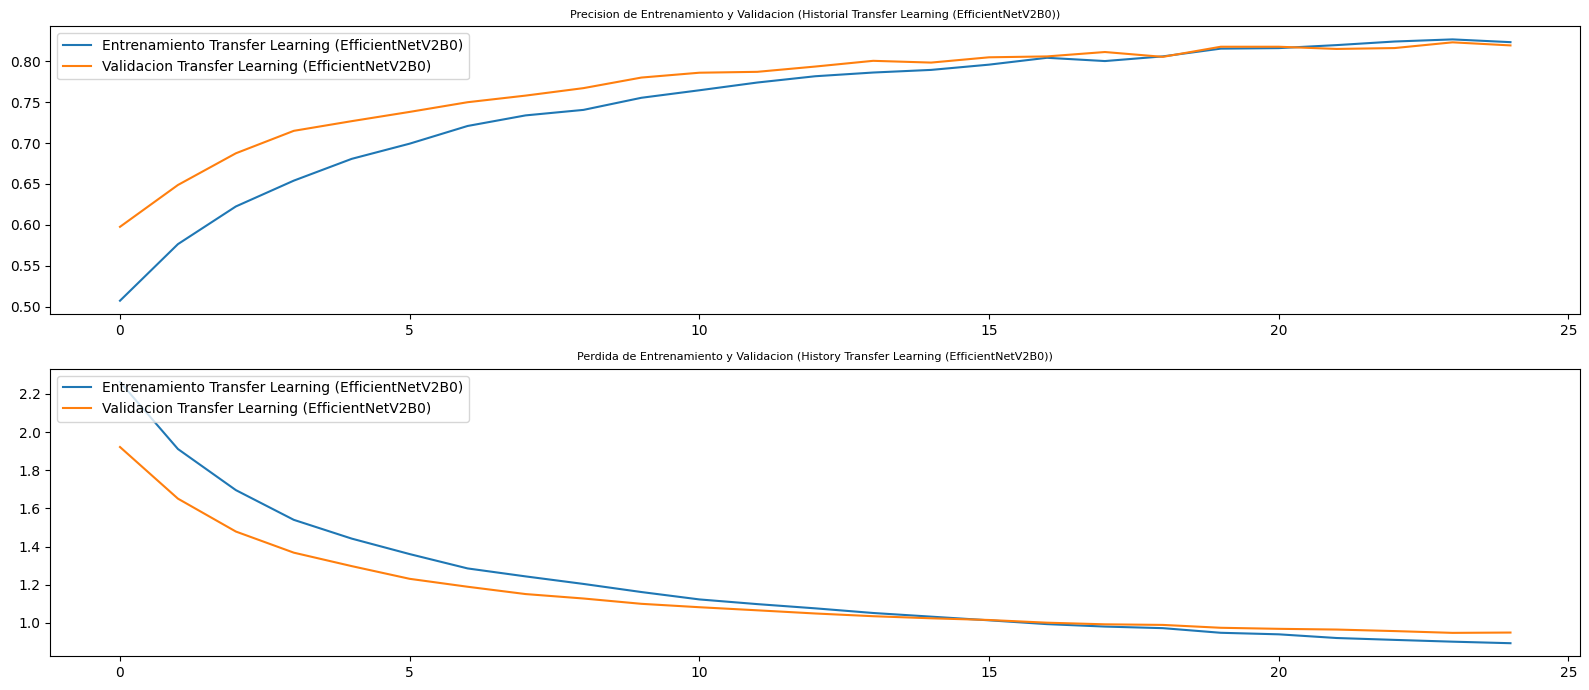

In [36]:
metrics_history_list = [metrics_history_tl]
best_models_labels = ["Transfer Learning (EfficientNetV2B0)"]

fig, axs = plt.subplots(2, 1, figsize=(16, 7))
axs_pairs = [[0,0]]
epochs_range = range(N_EPOCHS)

for ax_pair, metrics_history, method in zip(axs_pairs, metrics_history_list, best_models_labels):

    accuracy = metrics_history.history["accuracy"]
    val_accuracy = metrics_history.history["val_accuracy"]
    loss = metrics_history.history["loss"]
    val_loss = metrics_history.history["val_loss"]

    axs[0].plot(epochs_range, accuracy, label=f"Entrenamiento {method}")
    axs[0].plot(epochs_range, val_accuracy, label=f"Validacion {method}")
    axs[0].legend(loc="upper left")
    axs[0].set_title(f"Precision de Entrenamiento y Validacion (Historial {method})", fontsize=8)

    axs[1].plot(epochs_range, loss, label=f"Entrenamiento {method}")
    axs[1].plot(epochs_range, val_loss, label=f"Validacion {method}")
    axs[1].legend(loc="upper left")
    axs[1].set_title(f"Perdida de Entrenamiento y Validacion (History {method})", fontsize=8)

plt.tight_layout()
plt.show()

In [37]:
best_models = [best_tl_model]
test_sets = [test_ds]

best_models_acc = []

for model, method_label, test_set in zip(best_models, best_models_labels, test_sets):
  test_loss, test_accuracy = model.evaluate(test_set, verbose=2)
  best_models_acc.append(test_accuracy)
  print(f"Test accuracy of the best model for the {method_label} method: {test_accuracy:.4f}\n")

8/8 - 1s - 107ms/step - accuracy: 0.8077 - loss: 0.9483
Test accuracy of the best model for the Transfer Learning (EfficientNetV2B0) method: 0.8077



In [38]:
y_pred_probs = best_tl_model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 842ms/step


array([83, 83, 32, ..., 26, 71,  6])

In [39]:
y_true = []

for _, labels in test_ds:
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_true

array([83, 83, 32, ..., 26, 71,  6], dtype=int32)

In [40]:
print("Tamaños de arreglos de Predicciones y Etiquetas Reales de Prueba:", y_pred.shape, y_true.shape)

Tamaños de arreglos de Predicciones y Etiquetas Reales de Prueba: (1856,) (1856,)


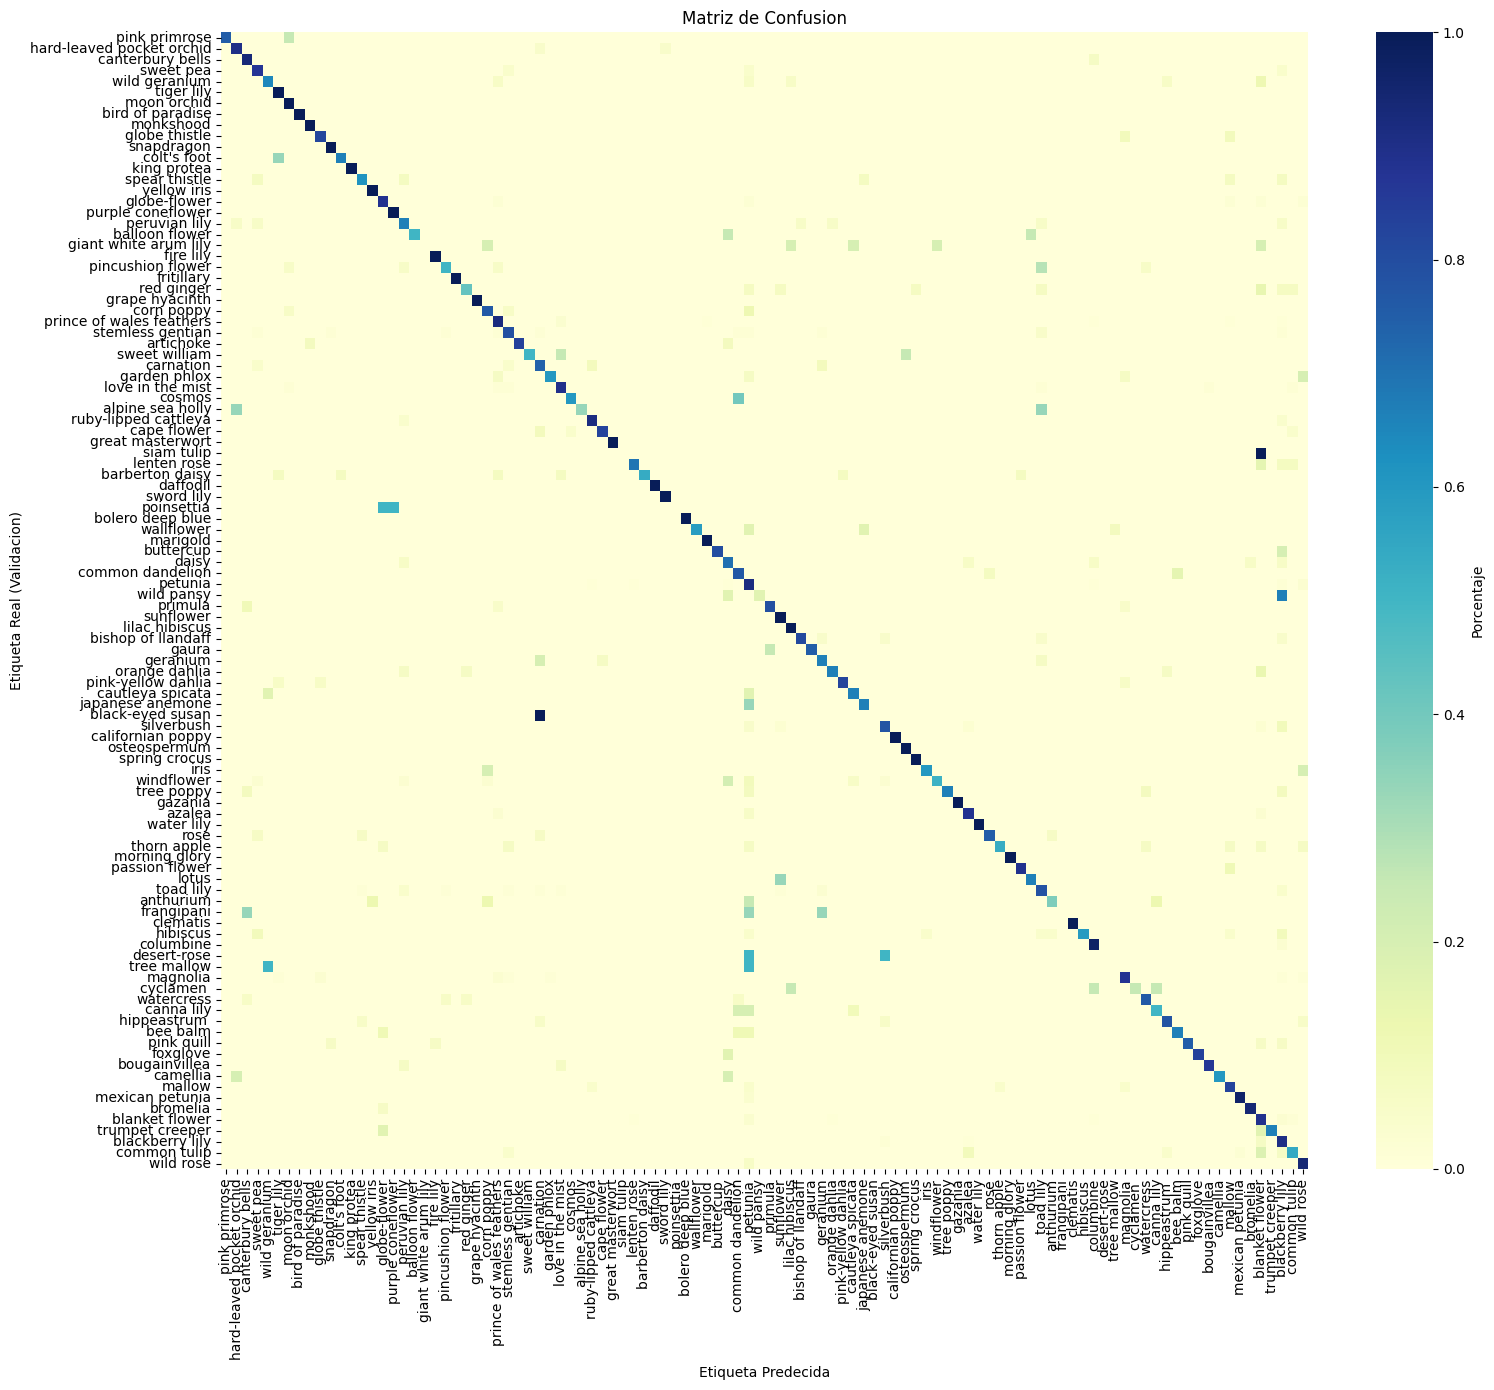

In [41]:
cm = confusion_matrix(y_true, y_pred, labels=range(len(CLASSES)))

cm_normalized = cm.astype("float") / cm.sum(axis=1, keepdims=True)

used_labels = sorted(list(set(y_true) | set(y_pred)))
used_names = [CLASSES[i] for i in used_labels]
cm_display = cm_normalized[np.ix_(used_labels, used_labels)]

plt.figure(figsize=(16, 14))
sns.heatmap(cm_display, xticklabels=used_names, yticklabels=used_names, cmap="YlGnBu", annot=False, fmt=".2f", cbar_kws={"label": "Porcentaje"})

plt.xlabel("Etiqueta Predecida")
plt.ylabel("Etiqueta Real (Validacion)")
plt.title("Matriz de Confusion")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [42]:
best_tl_model.export("tl_flower_classifier_lfmm")

Saved artifact at 'tl_flower_classifier_lfmm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 104), dtype=tf.float32, name=None)
Captures:
  134821809524560: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134821799352784: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  134821799352016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134821799349904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134821799347600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134821799351248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134821799351824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134821799348560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134821799352592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134821799352976: TensorSpec(shape=(), dtype=tf.resource

In [43]:
os.makedirs("tl_flower_classifier_tfjs_model_lfmm", exist_ok=True)

In [44]:
!tensorflowjs_converter --input_format=tf_saved_model ./tl_flower_classifier_lfmm ./tl_flower_classifier_tfjs_model_lfmm

2025-05-05 06:36:08.169745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746426968.190837   14949 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746426968.197321   14949 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-05 06:36:12.367053: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1746426972.367220   14949 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [45]:
!zip -r tl_flower_classifier_tfjs_model_lfmm.zip tl_flower_classifier_tfjs_model_lfmm/

updating: tl_flower_classifier_tfjs_model_lfmm/ (stored 0%)
updating: tl_flower_classifier_tfjs_model_lfmm/group1-shard4of6.bin (deflated 7%)
updating: tl_flower_classifier_tfjs_model_lfmm/group1-shard3of6.bin (deflated 7%)
updating: tl_flower_classifier_tfjs_model_lfmm/group1-shard6of6.bin (deflated 8%)
updating: tl_flower_classifier_tfjs_model_lfmm/model.json (deflated 96%)
updating: tl_flower_classifier_tfjs_model_lfmm/group1-shard2of6.bin (deflated 7%)
updating: tl_flower_classifier_tfjs_model_lfmm/group1-shard1of6.bin (deflated 7%)
updating: tl_flower_classifier_tfjs_model_lfmm/group1-shard5of6.bin (deflated 7%)
